In [24]:
import torch
import torch.nn as nn
from torch.autograd import Variable as V
from lib.Exercise1_1 import LQRSolver
from torch.utils.data import TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import time 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Setting data type and computing device for PyTorch
Proj_dtype = torch.double  # Use double precision for better accuracy
Proj_device = 'cpu'  # Use CPU for computation

# Define a deep neural network model
class DGMNN(nn.Module):
    def __init__(self):
        super(DGMNN, self).__init__()
        # Define three linear layers with 100 neurons each
        self.layer1 = nn.Linear(3, 100)  # Input layer (takes 3-dimensional input)
        self.layer2 = nn.Linear(100, 100)  # Hidden layer
        self.layer3 = nn.Linear(100, 100)  # Hidden layer
        # Define activation functions
        self.tanh = nn.Tanh()  # Tangent hyperbolic activation function
        self.relu = nn.ReLU()  # Rectified Linear Unit activation function
        # Define the output layer
        self.output = nn.Linear(100, 1)  # Output layer (produces 1-dimensional output)
        
    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.layer1(x))  # Activation after first layer
        x = self.tanh(self.layer2(x))  # Activation after second layer
        x = self.relu(self.layer3(x))  # Activation after third layer

        return self.output(x)  # Return the output of the network

In [25]:
class DGMNN2(nn.Module):
    """
    A deep neural network model for solving differential equations using the deep Galerkin method (DGM).
    This model incorporates residual connections, similar to a ResNet architecture, for improved training stability.
    """
    def __init__(self):
        super(DGMNN2, self).__init__()
        # Input layer: 3-dimensional input to 100-dimensional output
        self.layer1 = nn.Linear(3, 100)
        # Hidden layers: 100-dimensional input to 100-dimensional output
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        # Activation functions
        self.tanh = nn.Tanh()  # Tangent hyperbolic activation
        self.relu = nn.ReLU()  # Rectified Linear Unit activation
        # Output layer: 100-dimensional input to 1-dimensional output
        self.output = nn.Linear(100, 1)
        
    def forward(self, x):
        """
        Forward pass of the neural network with residual connections.
        
        Args:
            x (Tensor): The input tensor containing data points.
            
        Returns:
            Tensor: The output tensor of the network.
        """
        # First layer with ReLU activation
        out1 = self.relu(self.layer1(x))
        # Apply residual connection after second layer with Tanh activation
        identity = out1  # Save output of first layer for residual connection
        out2 = self.tanh(self.layer2(out1) + identity)  # Add the input of the layer (identity) to the output
        
        # Apply residual connection after third layer with ReLU activation
        identity = out2  # Update identity with output of second layer
        out3 = self.relu(self.layer3(out2) + identity)  # Add the updated identity to the output
        
        return self.output(out3)  # Return the final output of the network


In [26]:
def get_hessian(grad, x):
    """
    Computes the Hessian matrix of gradients for each element in x based on the given gradients.

    Args:
        grad (Tensor): The gradient of the output with respect to x, obtained from autograd.grad.
        x (Tensor): The input tensor with respect to which the Hessian is computed.

    Returns:
        Tensor: The Hessian matrix for each input element in x.
    """
    Hessian = torch.tensor([], device=Proj_device)  # Initialize empty tensor for storing Hessian matrices
    
    # Iterate over each element in x to compute second derivatives
    for i in range(len(x)):
        hessian = torch.tensor([], device=Proj_device)  # Temporary tensor for storing Hessian of the current element
        # Compute second derivative for each component of the gradient
        for j in range(len(grad[i])):
            # Compute the second derivative using autograd.grad
            u_xxi = torch.autograd.grad(grad[i][j], x, grad_outputs=torch.ones_like(grad[i][j]), 
                                        retain_graph=True, create_graph=True, allow_unused=True)[0]
            # Concatenate the second derivative to the temporary Hessian tensor
            hessian = torch.cat((hessian, u_xxi[i].unsqueeze(0)))
        # Concatenate the computed Hessian for the current element to the final Hessian tensor
        Hessian = torch.cat((Hessian, hessian.unsqueeze(0)), dim=0)
    
    return Hessian

def get_hessian_(model, t, x):
    """
    Alternative implementation for computing the Hessian matrix using a model's output.

    Args:
        model (nn.Module): The neural network model.
        t (Tensor): The time input tensor.
        x (Tensor): The spatial input tensor.

    Returns:
        Tensor: The Hessian matrix for each input element in x.
    """
    Hessian = torch.tensor([], device=Proj_device)  # Initialize empty tensor for Hessian matrices
    
    # Iterate over each element in the batch
    for i in range(len(t)):
        x_i = V(x[i], requires_grad=True)  # Make sure x_i requires gradient
        input = torch.cat(((t[i]).unsqueeze(0), x_i), dim=0)  # Concatenate time and space inputs
        u_in = model(input)  # Get model output
        # Compute the gradient of the output with respect to x_i
        grad = torch.autograd.grad(u_in, x_i, grad_outputs=torch.ones_like(u_in), 
                                   create_graph=True, retain_graph=True)[0]
        hessian = torch.tensor([], device=Proj_device)  # Temporary tensor for Hessian
        
        # Compute second derivatives for each component of the gradient
        for j in range(len(grad)):
            u_xxi = torch.autograd.grad(grad[j], x_i, grad_outputs=torch.ones_like(grad[j]), 
                                        retain_graph=True, create_graph=True, allow_unused=True)[0]
            # Concatenate the second derivative to the temporary Hessian tensor
            hessian = torch.cat((hessian, u_xxi.unsqueeze(0)))
        # Concatenate the computed Hessian for the current element to the final Hessian tensor
        Hessian = torch.cat((Hessian, hessian.unsqueeze(0)), dim=0)
    
    return Hessian

def pde_residual(model, t, x):
    """
    Computes the residual of the partial differential equation (PDE) using the neural network model.

    Args:
        model (nn.Module): The neural network model for approximating the solution.
        t (Tensor): The time input tensor.
        x (Tensor): The spatial input tensor.

    Returns:
        Tensor: The PDE residual for each input sample.
    """
    input = torch.cat((t.unsqueeze(1), x), dim=1)  # Concatenate time and spatial inputs
    u = model(input)  # Get model output
    
    # Compute time derivative of u with respect to t
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    # Compute spatial derivative of u with respect to x
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    # Compute second spatial derivative of u with respect to x
    u_xx = get_hessian(u_x, x)
    
    # Compute the residual of the PDE
    residual = u_t + 0.5 * torch.einsum('bii->b', sigma @ sigma.transpose(1, 2) @ u_xx) + \
               (u_x.unsqueeze(1) @ (H @ x.unsqueeze(1).transpose(1, 2)) + u_x.unsqueeze(1) @ M @ alpha + \
                x.unsqueeze(1) @ C @ x.unsqueeze(1).transpose(1, 2) + alpha.transpose(1, 2) @ D @ alpha).squeeze()
    
    return residual

def boundary_condition(model, t, x):
    """
    Computes the boundary condition for the neural network model.

    Args:
        model (nn.Module): The neural network model.
        t (Tensor): The time input tensor.
        x (Tensor): The spatial input tensor.

    Returns:
        Tensor: The computed boundary condition for each input sample.
    """
    T_input = T * torch.ones_like(t)  # Generate tensor of terminal times
    input = torch.cat((T_input.unsqueeze(1), x), dim=1)  # Concatenate terminal time and spatial inputs
    u = model(input)  # Get model output
    
    # Compute the boundary condition
    return u - (x.unsqueeze(1) @ R @ x.unsqueeze(1).transpose(1, 2)).squeeze()

def total_residual(model, t, x):
    """
    Computes the total residual combining both the PDE residual and the boundary condition.

    Args:
        model (nn.Module): The neural network model.
        t (Tensor): The time input tensor.
        x (Tensor): The spatial input tensor.

    Returns:
        Tensor: The total residual for each input sample.
    """
    residual_loss = pde_residual(model, t, x).pow(2).mean()  # Compute the mean squared PDE residual
    boundary_loss = boundary_condition(model, t, x).pow(2).mean()  # Compute the mean squared boundary condition
    
    return residual_loss + boundary_loss  # Return the sum of PDE residual and boundary condition losses


In [27]:
def new_data(num_samples):
    """
    Generates new random data for time samples and spatial samples.

    Args:
        num_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple containing tensors for time samples and spatial samples.
    """
    # Generate random time samples uniformly distributed between 0 and T
    t_samples = T * torch.rand(num_samples, dtype=Proj_dtype, device=Proj_device, requires_grad=True)
    # Define the spatial boundary
    x_ends = torch.tensor([-3, 3], dtype=Proj_dtype)
    # Generate random spatial samples uniformly distributed within the spatial boundary
    x_samples = x_ends[0] + (x_ends[1] - x_ends[0]) * torch.rand(num_samples, 2, dtype=Proj_dtype, device=Proj_device, requires_grad=True)
    return t_samples, x_samples

In [28]:
# Define matrices for LQR problem

H = torch.tensor([[1.2, 0.8], [-0.6, 0.9]], dtype=Proj_dtype, device = Proj_device)
M = torch.tensor([[0.5,0.7], [0.3,1.0]], dtype=Proj_dtype, device = Proj_device)
sigma = torch.tensor([[[0.08],[0.11]]], dtype=Proj_dtype, device = Proj_device)
alpha = torch.tensor([[[1],[1]]], dtype=Proj_dtype, device = Proj_device)
C = torch.tensor([[1.6, 0.0], [0.0, 1.1]], dtype=Proj_dtype, device = Proj_device)
D = torch.tensor([[0.5, 0.0], [0.0, 0.7]], dtype=Proj_dtype, device = Proj_device)
R = torch.tensor([[0.9, 0.0], [0.0, 1.0]], dtype=Proj_dtype, device = Proj_device)
T = torch.tensor(1.0, dtype=Proj_dtype, device = Proj_device)

# Initialize LQR solver with given matrices and settings
solver = LQRSolver(H, M, sigma, C, D, R, T=T, method="euler")


In [59]:
# Define different sample sizes for experimentation
samplesize = [100, 1000, 5000]
# Define number of epochs for training
epochs = 40
# Define batch size for training
Batch_size = 5

for sz in samplesize:

    # Initialize the neural network model
    model_DGM = DGMNN2().double()
    # stat_dict = torch.load('model2_DGM_state_dict.pt', map_location=torch.device('cpu'))
    # model_DGM.load_state_dict(stat_dict)
    #model_DGM = DGMNN().float().to(Proj_device)
    # Prepare for training: Define optimizer and learning rate scheduler
    optimizer_DGM = torch.optim.Adam(model_DGM.parameters(), lr=0.01)
    scheduler_DGM = lr_scheduler.ExponentialLR(optimizer_DGM, gamma=0.9)


    # List to store the average loss for each epoch
    epoch_losses = []

    # Create a new file to store epoch losses for the current sample size
    loss_filename = f'Exercise3/epoch_loss_{sz}.txt'
    with open(loss_filename, 'w') as file:
        file.write('Epoch,Loss\n')

    for batch in range(Batch_size):
        print(f'Batch {batch + 1}/{Batch_size}' + '\n')

        # Generate new data for the current batch
        t_data,x_data = new_data(sz)
        dataset = TensorDataset(t_data,x_data)
        dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

        for epoch in range(epochs):

            model_DGM.train()
            total_loss = 0
            
            for batch_idx, (t_data_,x_data_) in enumerate(dataloader):
                optimizer_DGM.zero_grad()
                # Wrap data with Variable for automatic differentiation
                t_v = V(t_data_,requires_grad=True)
                x_v = V(x_data_,requires_grad=True)
                # Compute the total residual loss
                loss = total_residual(model_DGM, t_v, x_v) 
                loss.backward(retain_graph=False)
                #loss.backward(retain_graph=True)
                optimizer_DGM.step()
                
                total_loss += loss.item()
            # Store the average loss for this epoch
            epoch_losses.append(total_loss / len(dataloader))

            # Adjust learning rate
            scheduler_DGM.step()
            # Print training progress
            if epoch == 0:
                print(f'Epoch {epoch+1}/{epochs} \t Loss: {total_loss / len(dataloader)}')
            if(epoch+1)% 10 == 0:
                torch.save(model_DGM.state_dict(), f'Exercise3/model2_DGM_state_dict_{sz}.pt')
            if (epoch+1) % 5 == 0:
                print(f'Epoch {epoch+1}/{epochs} \t Loss: {total_loss / len(dataloader)}')

        print('\n')

        # At the end of each batch, append the epoch losses to the file
        with open(loss_filename, 'a') as file:
            for i, loss in enumerate(epoch_losses, 1):
                file.write(f'{i},{loss}\n')
                
    # Set model to evaluation mode
    model_DGM.eval()

Batch 1/5

Epoch 1/40 	 Loss: 174.24934116613008
Epoch 5/40 	 Loss: 97.97454517718143
Epoch 10/40 	 Loss: 55.016093488863355
Epoch 15/40 	 Loss: 44.624411598407896
Epoch 20/40 	 Loss: 40.44729662718819
Epoch 25/40 	 Loss: 37.21147079524681
Epoch 30/40 	 Loss: 35.192210828578276
Epoch 35/40 	 Loss: 35.00448991881793
Epoch 40/40 	 Loss: 34.13497905158484


Batch 2/5

Epoch 1/40 	 Loss: 39.062453028968086
Epoch 5/40 	 Loss: 38.752469045172106
Epoch 10/40 	 Loss: 38.66329961379862
Epoch 15/40 	 Loss: 37.98371851579328
Epoch 20/40 	 Loss: 37.8250581563581
Epoch 25/40 	 Loss: 37.772765427889695
Epoch 30/40 	 Loss: 37.692621985353185
Epoch 35/40 	 Loss: 37.63902876588739
Epoch 40/40 	 Loss: 37.61164468334105


Batch 3/5

Epoch 1/40 	 Loss: 35.381719265333956
Epoch 5/40 	 Loss: 35.37164228146875
Epoch 10/40 	 Loss: 35.3980981062671
Epoch 15/40 	 Loss: 35.39135663571085
Epoch 20/40 	 Loss: 35.387178886355905
Epoch 25/40 	 Loss: 35.384665849798154
Epoch 30/40 	 Loss: 35.38317521620577
Epoch 35/4

In [43]:
def load_data_from_txt(file_path):
    """
    Loads training loss data from a txt file.

    Args:
        file_path (str): The file path of the txt file containing the training loss data.

    Returns:
        DataFrame: A pandas DataFrame containing the loaded data.
    """
    # Read the .txt file into a DataFrame
    df = pd.read_csv(file_path)
    return df

# Example usage of loading data
# Specify the paths to the files containing the training loss data for different sample sizes
file_path_100 = 'Exercise3/epoch_loss_100.txt'
file_path_1000 = 'Exercise3/epoch_loss_1000.txt'
file_path_5000 = 'Exercise3/epoch_loss_5000.txt'

# Load the data from txt files into DataFrames for further analysis and visualization
df_100 = load_data_from_txt(file_path_100)
df_1000 = load_data_from_txt(file_path_1000)
df_5000 = load_data_from_txt(file_path_5000)


     Epoch        Loss
0        1  174.249341
1        2  150.807328
2        3  132.610211
3        4  114.849114
4        5   97.974545
..     ...         ...
595    196   31.733956
596    197   31.733956
597    198   31.733956
598    199   31.733956
599    200   31.733956

[600 rows x 2 columns]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0      174.249341
1      150.807328
2      132.610211
3      114.849114
4       97.974545
          ...    
595     31.733956
596     31.733956
597     31.733956
598     31.733956
599     31.733956
Name: Loss, Length: 600, dtype: float64


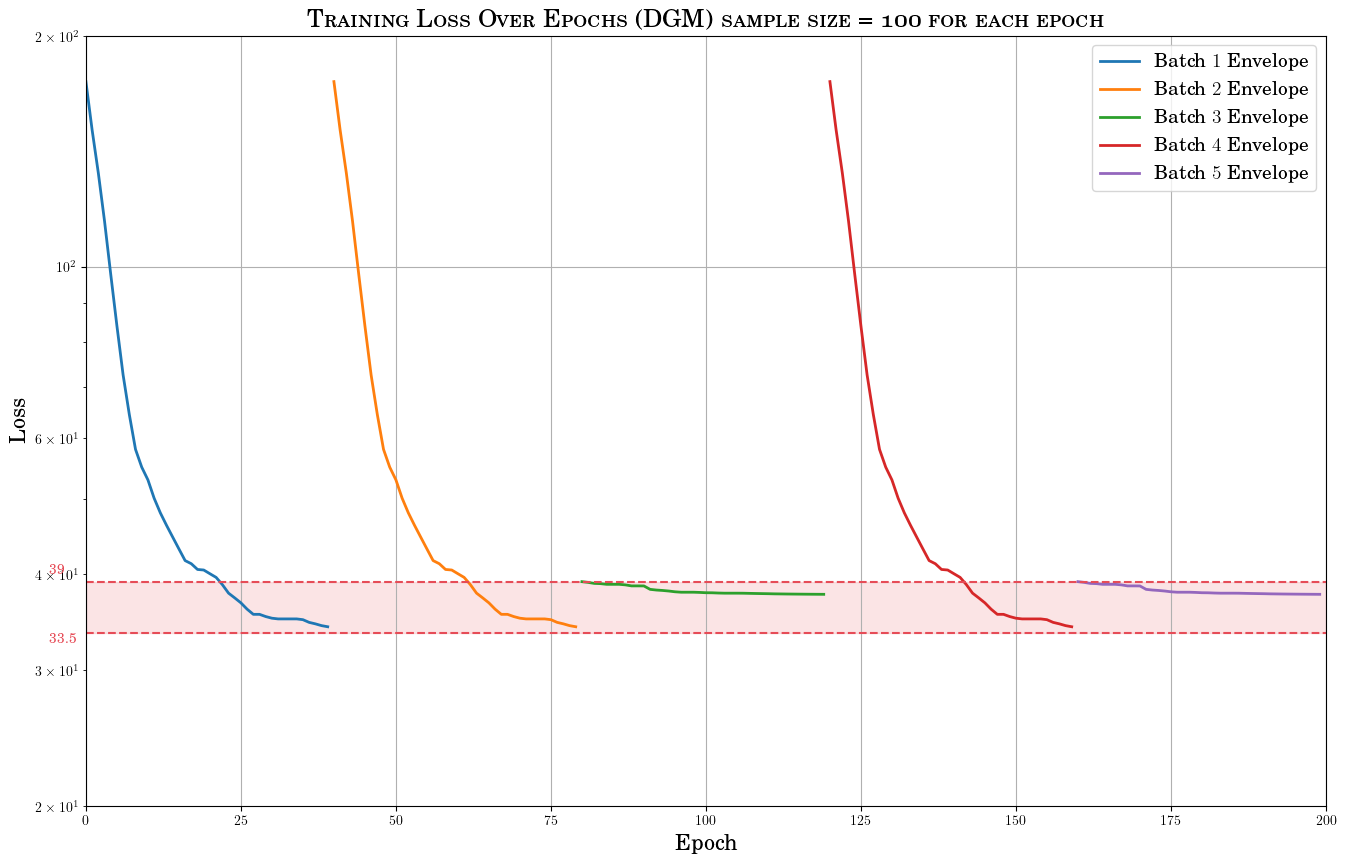

In [93]:
# Plotting training loss with customized settings
batch_size = 5  # Number of batches used during training
epoch = 40  # Number of epochs per batch

plt.rc('text', usetex=True)  # Enable LaTeX formatting for text in plots
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')  # Use the 'tgschola' LaTeX package for text styling

# Convert the 'Loss' column to numeric, coercing any errors that may occur due to non-numeric values
epoch_losses = pd.to_numeric(df_100['Loss'], errors='coerce')

# Calculate the envelope of the minimum loss values to visualize the progress over epochs
envelope_lower = np.minimum.accumulate(epoch_losses)

plt.figure(figsize=(16, 10))  # Set the figure size

# Iterate through each batch to plot its minimum envelope curve
epoch_list = range(batch_size * epoch)
for i in range(batch_size):
    start = i * epoch
    end = (i + 1) * epoch
    batch_epochs = epoch_list[start:end]
    batch_losses = epoch_losses[start:end]
    envelope_lower = np.minimum.accumulate(batch_losses)
    plt.plot(batch_epochs, envelope_lower, label=f'Batch {i+1} Envelope', lw=2)

# Horizontal lines and filled region to indicate convergence range
x = np.linspace(0, 200)
plt.axhline(y=33.5, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.axhline(y=39, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.fill_between(x, 33.5, 39, where=(x >= -20) & (x <= 220), color=(230/255, 76/255, 87/255, 0.15), interpolate=True)

plt.yscale('log')  # Set y-axis to logarithmic scale for better visualization of loss reduction
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training Loss Over Epochs (DGM) sample size = 100 for each epoch', fontsize=18)
plt.xlim(0, 200)  # Set x-axis limits
plt.ylim(2e1, 2e2)  # Set y-axis limits to focus on the significant range of loss values
plt.text(-6, 40, '39', color=(230/255, 76/255, 87/255), fontsize=10)  # Label the upper limit of the convergence range
plt.text(-6, 32.5, '33.5', color=(230/255, 76/255, 87/255), fontsize=10)  # Label the lower limit of the convergence range
plt.legend(fontsize=14)
plt.grid(True)  # Enable grid for better readability of the plot

plt.savefig('Exercise3/Training Loss_100 (DGM).eps', format='eps', dpi=600)  # Save the plot as EPS
plt.savefig('Exercise3/Training Loss_100 (DGM).png', format='png', dpi=600)  # Save the plot as PNG

plt.show()  # Display the plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0      140.258046
1       98.289556
2       70.091455
3       52.331147
4       41.707283
          ...    
595     23.908115
596     23.858974
597     23.914452
598     23.930575
599     23.882599
Name: Loss, Length: 600, dtype: float64


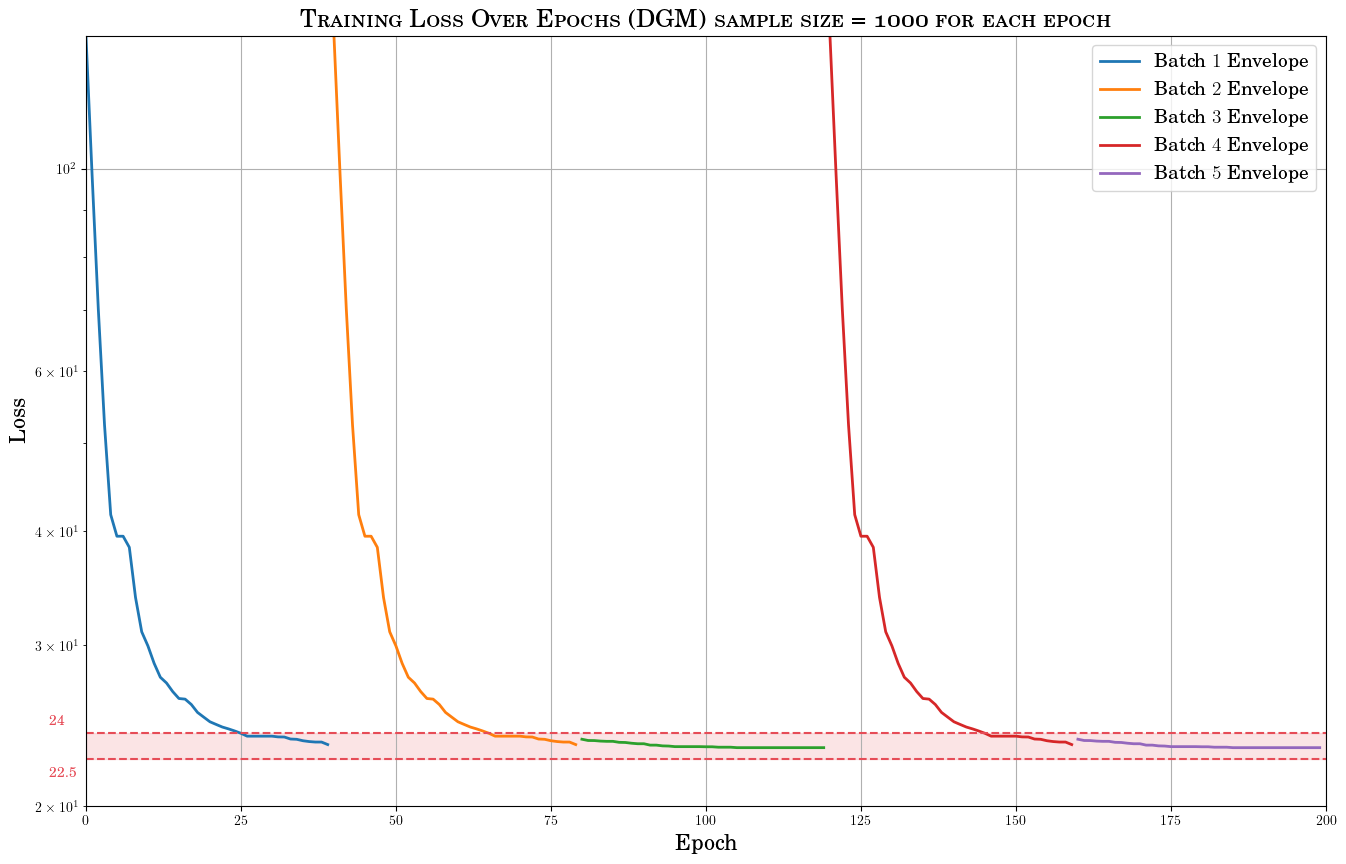

In [100]:
# Plotting the training loss with samplesize 1000
batch_size = 5
epoch = 40
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

# Convert epoch_losses to a numeric type if it's not already
epoch_losses = pd.to_numeric(df_1000['Loss'], errors='coerce')

envelope_lower = np.minimum.accumulate(epoch_losses)

plt.figure(figsize=(16, 10))

epoch_list = range(batch_size*epochs)
for i in range(batch_size):
    start = i * epochs
    end = (i + 1) * epochs
    batch_epochs = epoch_list[start:end]
    batch_losses = epoch_losses[start:end]
    
    envelope_lower = np.minimum.accumulate(batch_losses)
    
    plt.plot(batch_epochs, envelope_lower, label=r'\rmfamily \textmd {Batch }'+f'${i+1}$' r'\textmd{ Envelope}',lw=2)
x = np.linspace(0,200)
plt.axhline(y=22.5, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.axhline(y=24, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.fill_between(x, 22.5, 24, where=(x >= 0) & (x <= 220),color=(230/255, 76/255, 87/255, 0.15), interpolate=True)

plt.yscale('log')
plt.xlabel(r'\rmfamily \textmd {Epoch}', fontsize=16)
plt.ylabel(r'\rmfamily \textmd {Loss}', fontsize=16)
plt.title(r'\rmfamily {\textsc{Training Loss Over Epochs (DGM) sample size = 1000 for each epoch}}', fontsize=18)
plt.xlim(0,200)
plt.ylim(2e1, 1.4e2)  # Setting the y-axis limit to better visualize the decrease in loss
plt.text(-6, 24.5, r'\rmfamily \textmd {24}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.text(-6, 21.5, r'\rmfamily \textmd {22.5}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.legend(fontsize=14)
plt.grid(True)  # Add grid for better readability

plt.savefig('Exercise3/Training Loss_1000 (DGM).eps', format='eps', dpi=600)
plt.savefig('Exercise3/Training Loss_1000 (DGM).png', format='png', dpi=600)

plt.show()

0      82.281870
1      31.952974
2      22.914137
3      19.289235
4      17.406257
         ...    
595    14.134692
596    14.142847
597    14.141897
598    14.151494
599    14.178374
Name: Loss, Length: 600, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


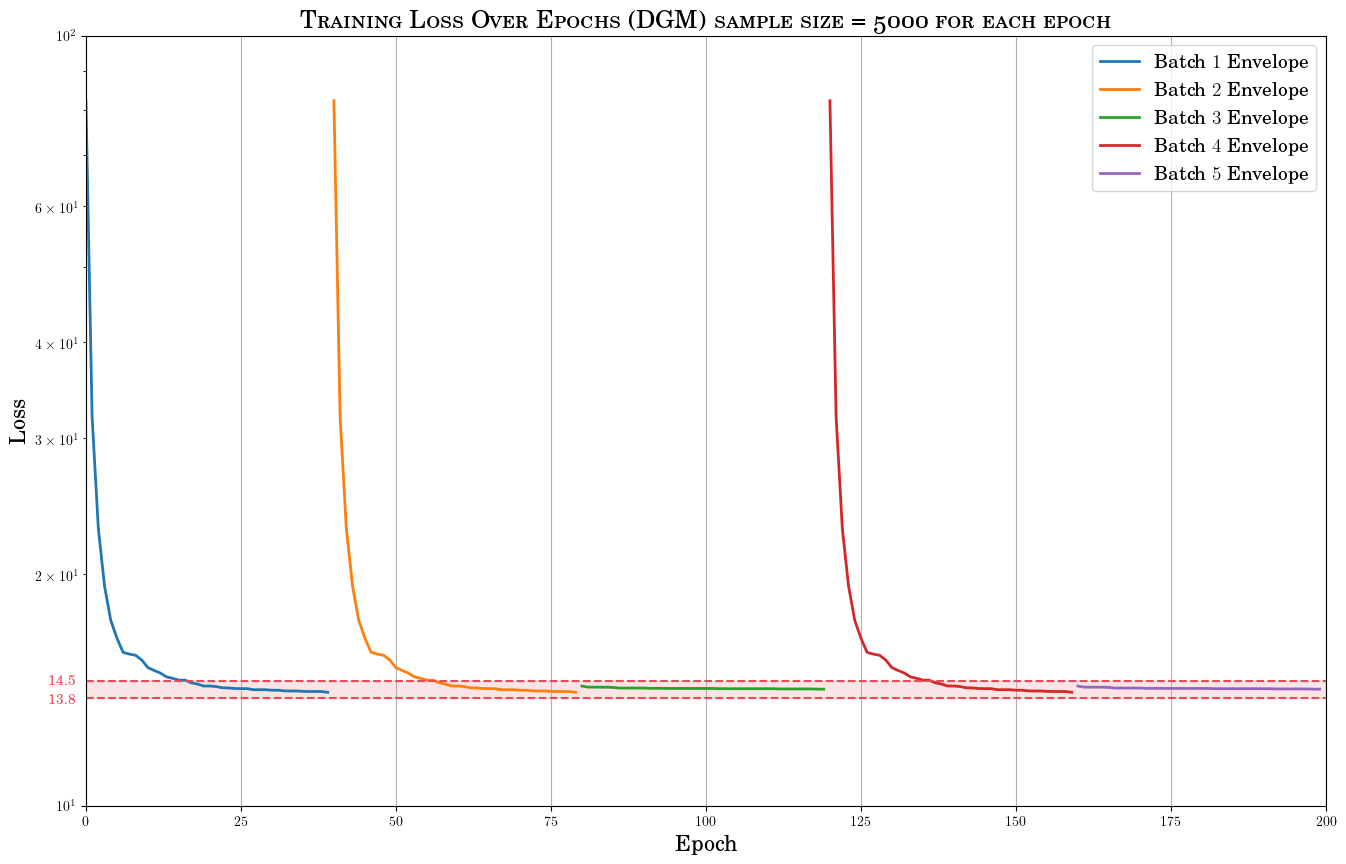

In [85]:
# Plotting the training loss with samplesize 5000
batch_size = 5
epoch = 40
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

# Convert epoch_losses to a numeric type if it's not already
epoch_losses = pd.to_numeric(df_5000['Loss'], errors='coerce')

envelope_lower = np.minimum.accumulate(epoch_losses)

plt.figure(figsize=(16, 10))

epoch_list = range(batch_size*epochs)
for i in range(batch_size):
    start = i * epochs
    end = (i + 1) * epochs
    batch_epochs = epoch_list[start:end]
    batch_losses = epoch_losses[start:end]
    
    envelope_lower = np.minimum.accumulate(batch_losses)
    
    plt.plot(batch_epochs, envelope_lower, label=r'\rmfamily \textmd {Batch }'+f'${i+1}$' r'\textmd{ Envelope}',lw=2)
x = np.linspace(0,200)
plt.axhline(y=13.8, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.axhline(y=14.5, xmin=0, xmax=200, color=(230/255, 76/255, 87/255), linestyle='--')
plt.fill_between(x, 13.8, 14.5, where=(x >= -20) & (x <= 220),color=(230/255, 76/255, 87/255, 0.15), interpolate=True)

plt.yscale('log')
plt.xlabel(r'\rmfamily \textmd {Epoch}', fontsize=16)
plt.ylabel(r'\rmfamily \textmd {Loss}', fontsize=16)
plt.title(r'\rmfamily {\textsc{Training Loss Over Epochs (DGM) sample size = 5000 for each epoch}}', fontsize=18)
plt.xlim(0,200)
plt.ylim(1e1, 1e2)  # Setting the y-axis limit to better visualize the decrease in loss
plt.text(-6, 14.4, r'\rmfamily \textmd {14.5}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.text(-6, 13.6, r'\rmfamily \textmd {13.8}', color=(230/255, 76/255, 87/255), fontsize=10)
plt.legend(fontsize=14)
plt.grid(True)  # Add grid for better readability

plt.savefig('Exercise3/Training Loss_5000 (DGM).eps', format='eps', dpi=600)
plt.savefig('Exercise3/Training Loss_5000 (DGM).png', format='png', dpi=600)

plt.show()

In [103]:
# Load interval settings for Monte Carlo simulations
load_interval_setting = torch.load('Exercise3_MC/value_numerical/3x3/'+'interval_setting.pt')
t_ends = load_interval_setting['t_ends']
t_num = load_interval_setting['t_num']
x_ends = load_interval_setting['x_ends']
x_num = load_interval_setting['x_num']

# Establish meshgrid structure for numerical solution
# This section generates a meshgrid for t and x, allowing us to compute the value function over a grid of time and state space
t_batch_i = torch.linspace(t_ends[0],t_ends[1],t_num,dtype=torch.double)  # Generate time points
t_batch = t_batch_i.repeat_interleave(x_num[0]*x_num[1])  # Repeat each time point for all combinations of state space

x1 = torch.linspace(x_ends[0][0],x_ends[0][1],x_num[0],dtype=torch.double)  # Generate points for the first dimension of state space
x2 = torch.linspace(x_ends[1][0],x_ends[1][1],x_num[1],dtype=torch.double)  # Generate points for the second dimension of state space

x_batch = torch.cartesian_prod(x1, x2).unsqueeze(1).repeat(t_num, 1, 1)  # Generate all combinations of state space points for each time point

x_batch_i = torch.cartesian_prod(x1, x2).unsqueeze(1)  # Generate all combinations of state space points

X1 = x_batch_i[:, 0, 0].view(x_num[0], x_num[1])  # Reshape for plotting
X2 = x_batch_i[:, 0, 1].view(x_num[0], x_num[1])  # Reshape for plotting


In [104]:
# Prepare for Monte Carlo simulations
file_path_MC_FSS = 'Exercise3_MC'+ '/' + f'value_MC/{x_num[0]}x{x_num[1]}/FSS_1e5'  # Path where MC results are stored

FSS_VTSN = [int(x) for x in[5e3]]  # Define the fixed sampling size for varied time step numbers

MSE_FSS_VTSN = []  # To store the Mean Squared Errors for each time step number
J = []  # To store the computed J values from Monte Carlo simulations

# Iterate over each time step number to load and process the MC simulation results
for i in FSS_VTSN:
    trvlthg = 's' if i != 1 else ''  # Handle singular vs plural step
    path_FSS_VTSN_i = f"{file_path_MC_FSS}/{i}_step{trvlthg}"  # Construct the path for current step number

    J_load_test = torch.load(path_FSS_VTSN_i + '/value_MC.pt')  # Load the MC results
    
    J_processed,_ = torch.min(J_load_test,dim = 1)  # Process the MC results to find minimum J values

    J.append(J_processed)  # Append processed results for comparison and analysis

In [106]:
# Load the DGM model trained with sample size 100
model_DGM = DGMNN2().double()
stat_dict = torch.load('model2_DGM_state_dict_100.pt', map_location=torch.device('cpu'))  # Load the model's state dict
model_DGM.load_state_dict(stat_dict)  # Apply the loaded state dict to the model

# Prepare the data for prediction
t_data = t_batch  # Time data
x_data = x_batch.squeeze(1)  # State data, making sure it's the correct shape

# Predict the value function using the loaded model
J_model = model_DGM(torch.cat((t_data.unsqueeze(1), x_data),dim=1)).squeeze()  # Model predictions


<All keys matched successfully>

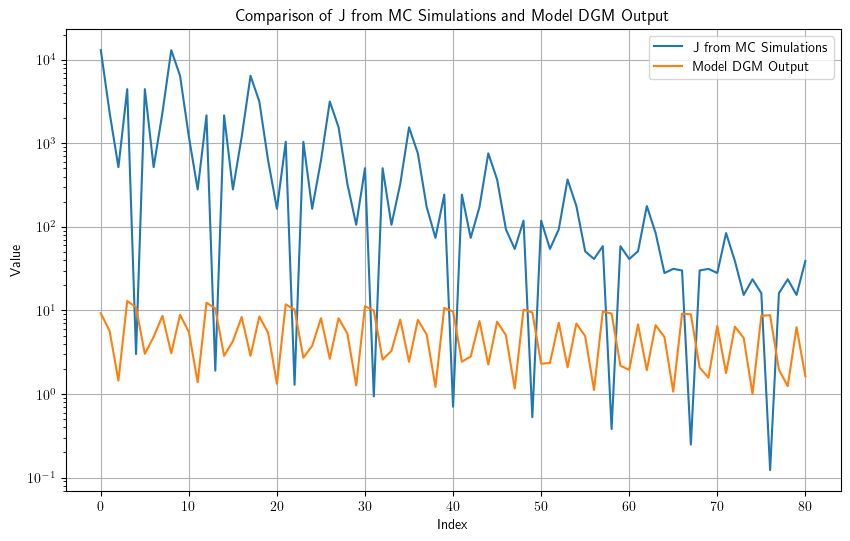

In [111]:
# Plotting the comparison between J (from MC simulations) and model predictions
plt.figure(figsize=(10, 6))
plt.plot(J[0].numpy(), label = 'J from MC Simulations')  # Plotting J values obtained from Monte Carlo simulations
plt.plot(J_model.detach().numpy(), label='Model DGM Output')  # Plotting the model's output for comparison

plt.yscale('log')  # Use a logarithmic scale for the y-axis to better visualize differences across magnitudes
plt.xlabel('Index')  # The x-axis represents the index or position of each data point
plt.ylabel('Value')  # The y-axis represents the value function or control action predicted by the model
plt.title('Comparison of J from MC Simulations and Model DGM Output')  # Title of the plot
plt.legend()  # Include a legend to distinguish between the curves
plt.grid(True)  # Enable grid for better readability

plt.show()  # Display the plot
